#MealPlanAI NLP Conversational Model with Multilingual Capability

The goal of this prototype is to have a prototype for a chatbot that can potentially be used for [MealPlanAI](https://github.com/jguss45/MealPlanAI), a web app I am working on for creating AI generated meal plans

This protoype will have the following components:
- Front-end. Front-end will be delivered with Gradio
- Translation service - [Google Translation AI](https://cloud.google.com/translate)
- Conversational Engine - [Google Dialogflow ](https://cloud.google.com/dialogflow)

Connecting to our drive containing working directory:



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Libraries

In [ ]:
!pip install gradio
!pip install google-cloud-dialogflow
!pip install google-cloud-translate==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.cloud import dialogflow
import uuid

In [ ]:
from google.cloud import translate_v2 as translate

#### Conversational model in DialogFlow

Example images showing the conversational model in DialogFlow. Here are two images showing the welcome intent

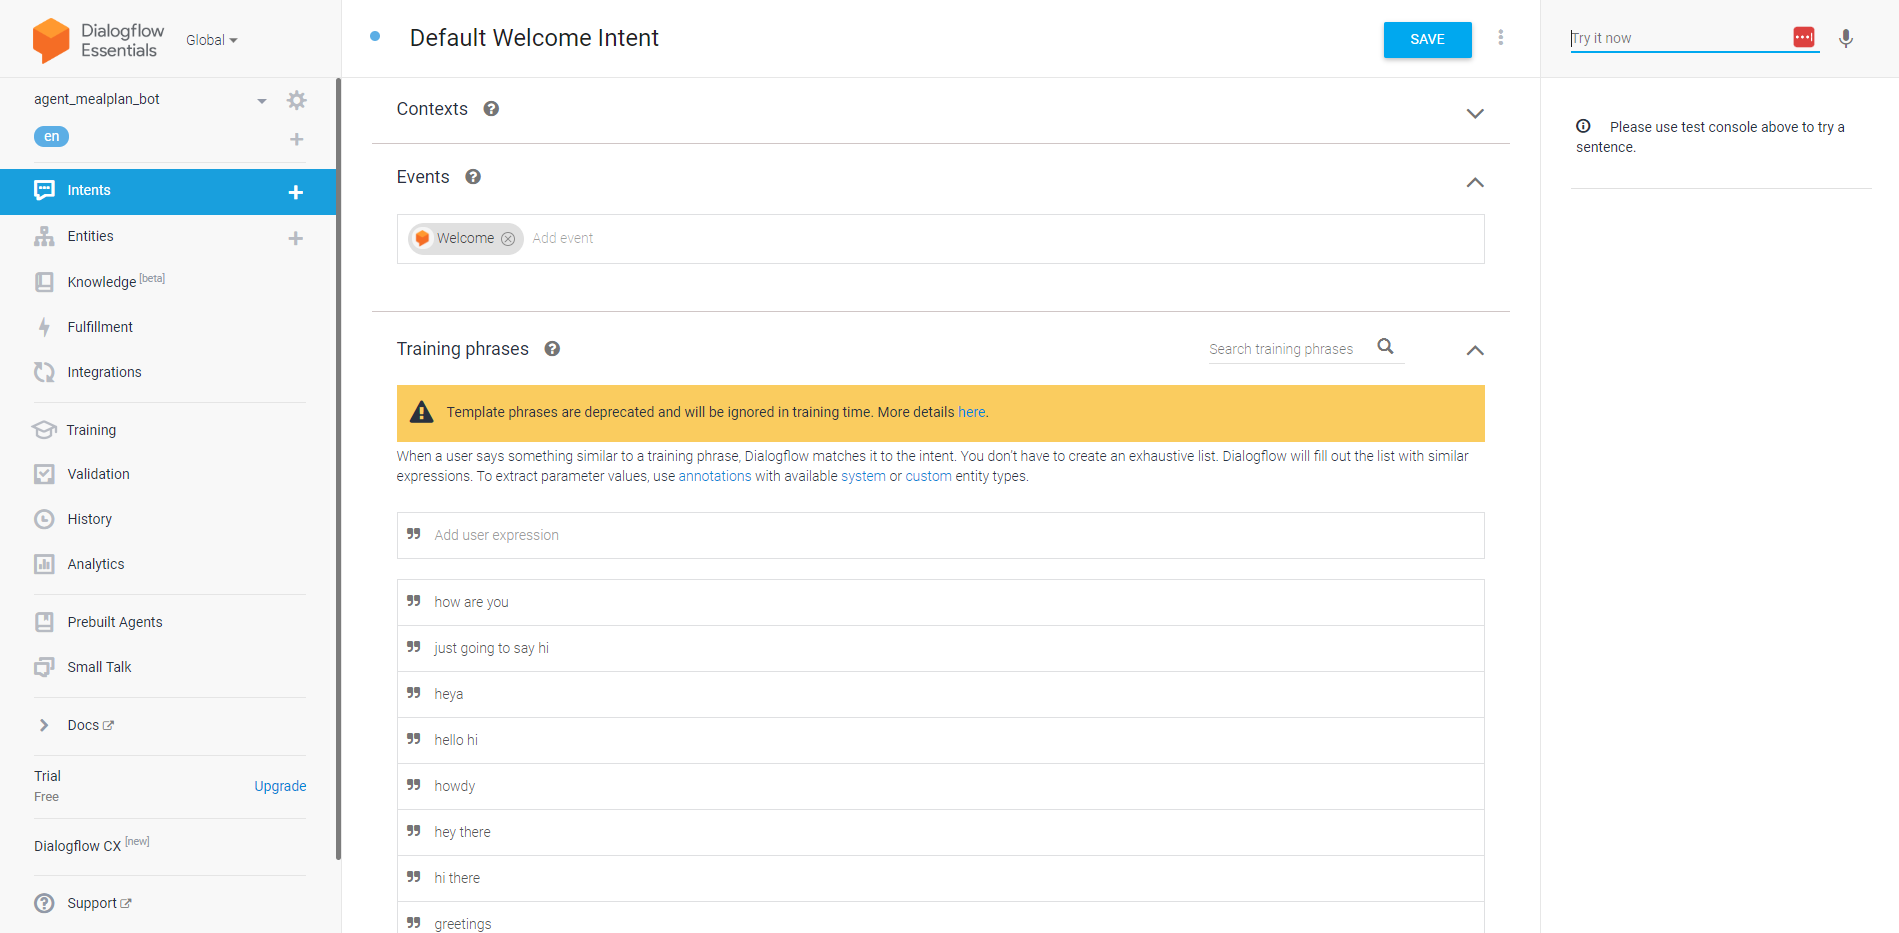

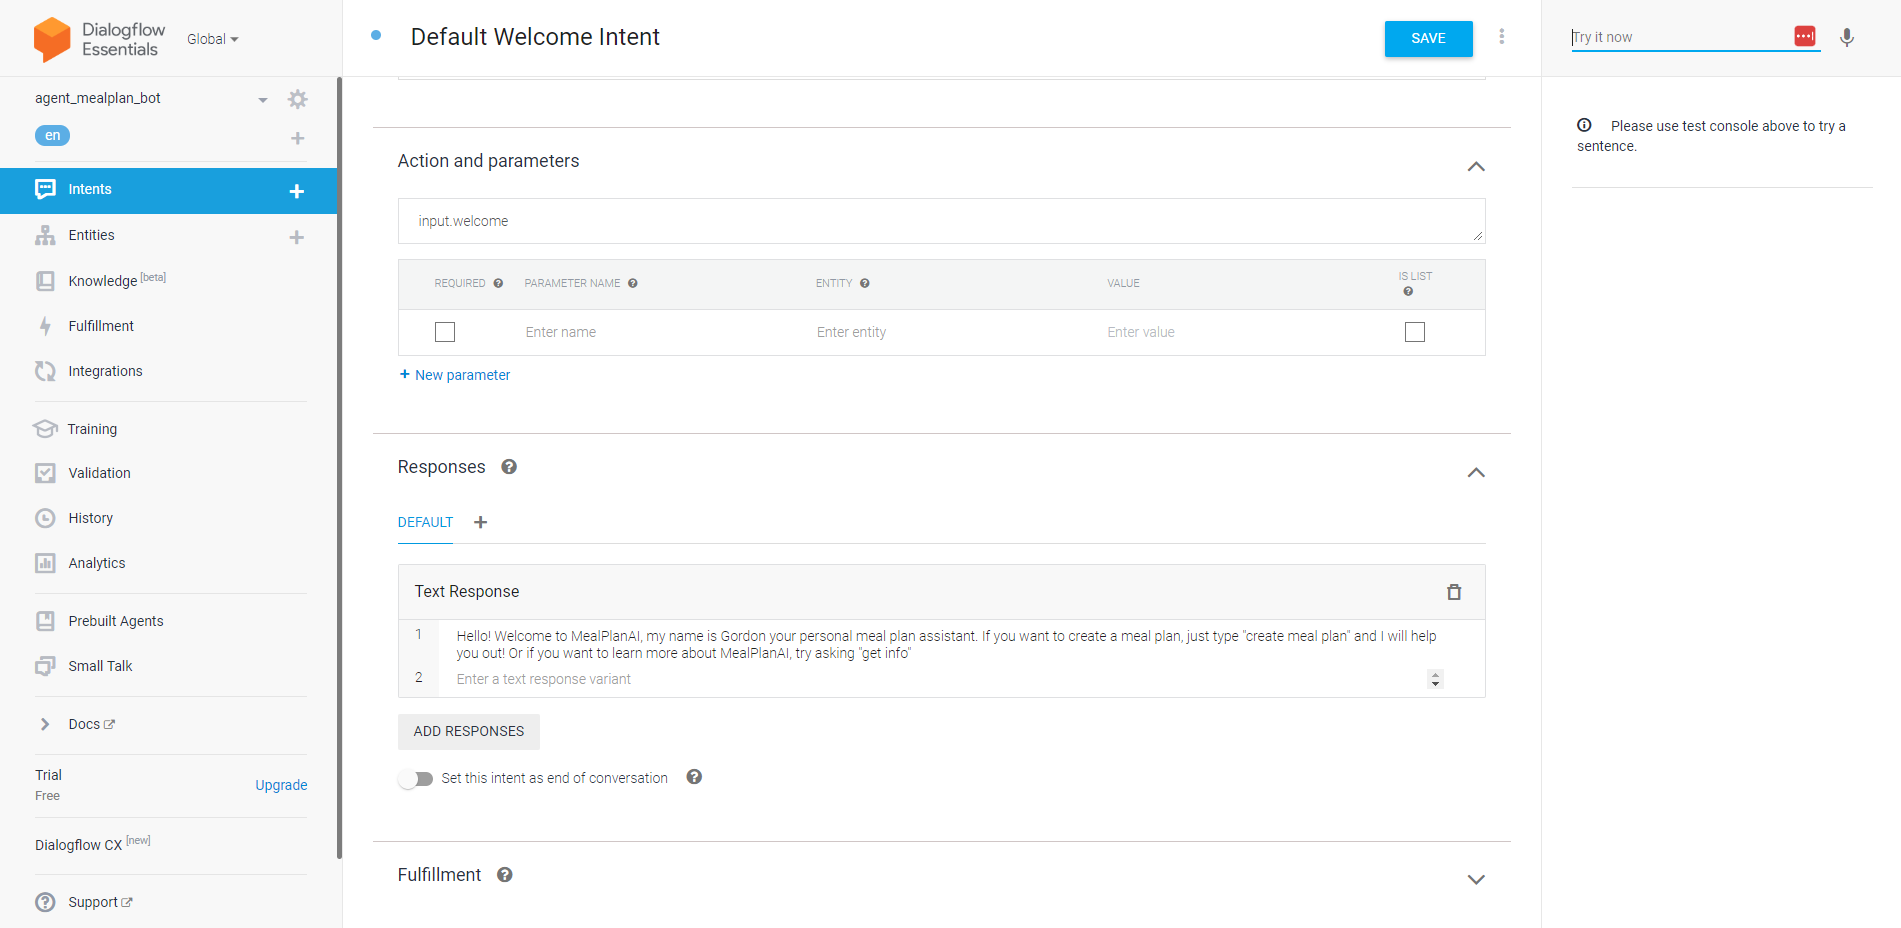

#####**Authentication**


In order to use the connect with DialogFlow and the required google APIs, we have to authenticate using our credentials stored in drive:


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file('/content/drive/MyDrive/Colab Notebooks/NLP/multilingual_model/credentials.json')

**Session**

Must create a session which will represent a conversation between the Dialogflow agent and an end-user. This session will be created at the start of the conversation and discontinued once the conversation ends. 


In [ ]:
session_id = uuid.uuid4().hex
project_id = "agent-airline-bot-uqvh"
language_code = 'en'

In [ ]:
#create the session client with the credentials
session_client = dialogflow.SessionsClient(credentials=credentials)

session = session_client.session_path(project_id, session_id)

#####Conversational model interface

Importing required libraries and creating a function to make a request to our conversational model in DialogFlow

In [ ]:
import gradio as gr
import random
import time

In [ ]:
def dialogflow_request(text, language_code):
    text_input = dialogflow.TextInput(text=text, language_code=language_code)
    query_input = dialogflow.QueryInput(text=text_input)
    response = session_client.detect_intent(
        request={"session": session, "query_input": query_input}
    )
    return response

#### Integrating Google's translation API with DialogFlow agent and the Gradio Frontend to demonstrate the MVP of the conversation model. The flow will be as illustrated:

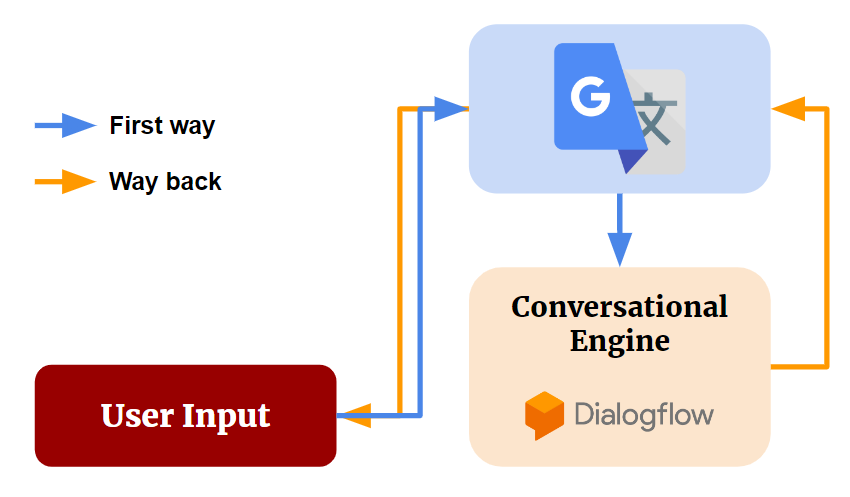

In [ ]:
with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")
    translate_client = translate.Client(credentials=credentials)

    def respond(message, chat_history):
        #detect language
        lang_detect = translate_client.detect_language(message)
        #1. if language is english with confidence >= .90 then go straight to conv engine
        if lang_detect["language"] == 'en' and lang_detect["confidence"] >= .90:
          #Feed message to conv engine and get response
          response = dialogflow_request(message, 'en')
          #We get the answer from the response of Dialogflow
          bot_message = str(response.query_result.fulfillment_messages[0].text.text[0])
          chat_history.append((message, bot_message))
          time.sleep(1)
          return "", chat_history
        #2. if language is english with confidence <= .90 then translate and go to conv engine then return output
        elif lang_detect["language"] == 'en' and lang_detect["confidence"] < .90:
          translated_msg = translate_client.translate(message, target_language='en')
          #Feed message to conv engine and get response
          response = dialogflow_request(translated_msg["translatedText"], 'en')
          #We get the answer from the response of Dialogflow
          bot_message = str(response.query_result.fulfillment_messages[0].text.text[0])
          chat_history.append((message, bot_message))
          time.sleep(1)
          return "", chat_history
        #3. if not english then translate to english and send to conv engine and then translate response and return message to user
        else: 
          translated_msg = translate_client.translate(message, target_language='en')
          #Feed message to conv engine and get response
          response = dialogflow_request(translated_msg["translatedText"], 'en')
          #We get the answer from the response of Dialogflow and translate it to the original detected language
          bot_message = str(response.query_result.fulfillment_messages[0].text.text[0])
          translated_bot_msg = translate_client.translate(bot_message, target_language=lang_detect["language"])
          chat_history.append((message, translated_bot_msg["translatedText"]))
          time.sleep(1)
          return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)

demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>